In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.vision.gan import *
from urllib.parse import urlparse
import torch.nn as nn
import torch.nn.functional as F

# DATA

In [2]:
realImagesPath = untar_data("http://vis-www.cs.umass.edu/lfw/lfw-a")
realImagesPath

PosixPath('/root/.fastai/data/lfw-a')

In [0]:
# For whatever reason the "-a" isn't included in the folder name by tarfile.extractall
realImagesPath = realImagesPath.parent/'lfw'

In [0]:
sampleImg1Path = realImagesPath/'Aaron_Eckhart/Aaron_Eckhart_0001.jpg'

In [5]:
from PIL import Image

im = Image.open(sampleImg1Path)
im.size

(250, 250)

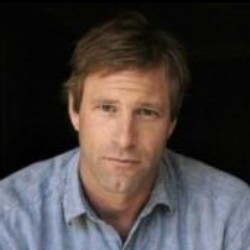

In [6]:
from IPython.display import Image
Image(filename=str(sampleImg1Path))


GANItemList stores NoisyItem's in x and the input images in y (target)

In [0]:
def get_data(path, bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

# CRITIC

In [0]:
# PLATFORM DEPENDENT CODE !!!!
def mount_gdrive():
  root_dir = '/content'

  if (importlib.util.find_spec("google.colab") is not None):
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    root_dir = "/content/gdrive/My Drive/"
  
  return root_dir

In [0]:
def get_critic_pkl_dir():
  # Replace with code to get pkl from your source
  root_dir = mount_gdrive()
  rel_path = 'ML/'
  return root_dir + rel_path

Load a pretrained discriminator. Pending research about whether it's good to start with a pretrained one, kind of more knolewdgeable than the generator.

In [0]:
critic = load_learner(get_critic_pkl_dir(), 'faceBinaryClassifierResnet18_1.pkl')

In [0]:
def loadNewTestImage(url: str, filename: str, testRootDir:Path):
  parsedUrl = urlparse(url)
  ext = os.path.splitext(parsedUrl.path)[1]
  path = testRootDir/(filename + ext)
  download_url(url, path)
  img = open_image(path)
  return img

Fastai managed image, stored as a Tensor with values in [0..1]

In [0]:
img = loadNewTestImage('https://live.staticflickr.com/3844/14761664536_f875cf6b9c_b.jpg', 'fakeFace', Path('/content'))
img

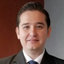

In [14]:
img = loadNewTestImage('https://i1.rgstatic.net/ii/profile.image/679664246865925-1539055992441_Q64/Leonardo_Glasserman.jpg', 'realFace64x64', Path('/content'))
img

Predict automatically resizes input image to 224x224 before making the forward pass

In [15]:
critic.predict(img)

(Category positive, tensor(1), tensor([3.4406e-12, 1.0000e+00]))

---
Manually evaluate an input of size 64x64. This shouldn't be right, as it seems minimum input size expected is 224x224

In [16]:
batch_one_item = img._px.unsqueeze(0)
batch_one_item.size(), F.softmax(critic.model(batch_one_item), dim=-1)

(torch.Size([1, 3, 64, 64]),
 tensor([[8.4696e-05, 9.9992e-01]], grad_fn=<SoftmaxBackward>))

In [0]:
??critic.data.single_ds.set_item
??critic.predict
??critic.data.one_item
#   ??critic.data.single_ds.set_item
#   ??critic.data.single_ds.x.process_one
#   ??critic.data.single_ds.x.processor
??critic.data.one_batch
??critic.data.train_dl

---
Getting the predictions for a size 1 batch

In [17]:
batch1 = critic.data.one_item(img) # creates a size 1 batch; previously resizes image to 224x224, so it's (1, 3, 224, 224)
result1 = critic.pred_batch(batch=batch1)
result1, batch1[0].size()
# predictions return are the result of grab_idx(result1, 0, batch_first=True). grab_idx just takes the predictions for batch passed (0 here), indexed according to batch_first
# ??critic.predict


(tensor([[3.4406e-12, 1.0000e+00]]), torch.Size([1, 3, 224, 224]))

---
Stuff called from learner.pred_batch, used here for deeper understanding of the details

In [0]:
loss_func_name2activ = {'cross_entropy_loss': F.softmax, 'nll_loss': torch.exp, 'poisson_nll_loss': torch.exp,
    'kl_div_loss': torch.exp, 'bce_with_logits_loss': torch.sigmoid, 'cross_entropy': F.softmax,
    'kl_div': torch.exp, 'binary_cross_entropy_with_logits': torch.sigmoid,
}

def _loss_func_name2activ(name:str, axis:int=-1):
    res = loss_func_name2activ[name]
    if res == F.softmax: res = partial(F.softmax, dim=axis)
    return res

def _loss_func2activ(loss_func):
    if getattr(loss_func,'keywords',None):
        if not loss_func.keywords.get('log_input', True): return
    axis = getattr(loss_func, 'axis', -1)
    # flattened loss
    loss_func = getattr(loss_func, 'func', loss_func)
    # could have a partial inside flattened loss! Duplicate on purpose.
    loss_func = getattr(loss_func, 'func', loss_func)
    cls_name = camel2snake(loss_func.__class__.__name__)
    if cls_name == 'mix_up_loss':
        loss_func = loss_func.crit
        cls_name = camel2snake(loss_func.__class__.__name__)
    if cls_name in loss_func_name2activ:
        if cls_name == 'poisson_nll_loss' and (not getattr(loss_func, 'log_input', True)): return
        return _loss_func_name2activ(cls_name, axis)
    if getattr(loss_func,'__name__','') in loss_func_name2activ:
        return _loss_func_name2activ(loss_func.__name__, axis)
    return noop

---

Manually getting the activations for the model of the critic (not proper way to do it)

In [0]:
??critic.pred_batch
# pred_batch does...
# preds = loss_batch(self.model.eval(), xb, yb, cb_handler=cb_handler)
#      out = model(xb)
#      return loss_func(out, yb)
# res = _loss_func2activ(self.loss_func)(preds[0])
# return res

In [19]:
xb, yb = batch1
out1 = critic.model(xb)
# critic.loss_func(out1, yb)
lf1 = _loss_func2activ(critic.loss_func) # softmax
lf1(out1)

tensor([[3.4406e-12, 1.0000e+00]], grad_fn=<SoftmaxBackward>)

---
Playing with softmax...

In [20]:
t1 = Tensor([[2, -2, 1], [-20, -20, 3]])
# dim = 0 -> first dimension, dim = 1 -> second dimension, ...; dim = -1 -> last dimension
softmaxDim0 = F.softmax(t1, dim=0)
softmaxDim1 = F.softmax(t1, dim=1) 
softmaxDimMinus1 = F.softmax(t1, dim=-1)
softmaxDim0, softmaxDim1, softmaxDimMinus1

(tensor([[1.0000e+00, 1.0000e+00, 1.1920e-01],
         [2.7895e-10, 1.5230e-08, 8.8080e-01]]),
 tensor([[7.2140e-01, 1.3213e-02, 2.6539e-01],
         [1.0262e-10, 1.0262e-10, 1.0000e+00]]),
 tensor([[7.2140e-01, 1.3213e-02, 2.6539e-01],
         [1.0262e-10, 1.0262e-10, 1.0000e+00]]))

---
Calling transforms manually (again, just a test, not proper way to do it)

In [21]:
t1 = torch.Tensor(1)
t1[0] = 3.5
# Add dimension of size 1 (like wrapping aaa in another vector)
t1.unsqueeze_(0)
t1.size()
t2 = None
# batch1 = critic.data.one_item(img)
for f in listify(critic.data.tfms): t2 = f(batch1)
t1, t1.size(), t2

(tensor([[3.5000]]),
 torch.Size([1, 1]),
 (tensor([[[[-4.8497, -4.8497, -4.8497,  ..., -3.0478, -3.0316, -3.0154],
            [-4.8497, -4.8452, -4.8406,  ..., -3.0316, -3.0154, -2.9992],
            [-4.8497, -4.8406, -4.8314,  ..., -3.0154, -2.9992, -2.9831],
            ...,
            [-4.7127, -4.7451, -4.7775,  ..., -7.5340, -7.5389, -7.5438],
            [-4.8099, -4.8423, -4.8747,  ..., -7.5065, -7.5252, -7.5438],
            [-4.9071, -4.9394, -4.9718,  ..., -7.4791, -7.5115, -7.5438]],
  
           [[-7.0723, -7.0723, -7.0723,  ..., -2.5703, -2.5541, -2.5379],
            [-7.0723, -7.0677, -7.0632,  ..., -2.5541, -2.5379, -2.5216],
            [-7.0723, -7.0632, -7.0540,  ..., -2.5379, -2.5216, -2.5054],
            ...,
            [-4.5718, -4.6113, -4.6507,  ..., -7.0050, -7.0100, -7.0149],
            [-4.5880, -4.6321, -4.6761,  ..., -6.9776, -6.9962, -7.0149],
            [-4.6042, -4.6528, -4.7015,  ..., -6.9501, -6.9825, -7.0149]],
  
           [[-6.4260, -6.426

# GENERATOR

In [22]:
#Testing a transpose convolution
input = torch.rand(64, 100, 1, 1)
nn.ConvTranspose2d(100, 1024, 4, padding=0, stride=1)(input).size()

torch.Size([64, 1024, 4, 4])

In [0]:
class ConvTransBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvTransBlock, self).__init__()
    self.conv = nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, (4, 4), padding=1, stride=2),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )
    
  def forward(self, x):
    return self.conv(x)

class GeneratorNet(nn.Module):
  def __init__(self):
    super(GeneratorNet, self).__init__()
    self.layers = nn.Sequential(
      #nn.Linear(100, 1024 * 4 * 4),
      nn.ConvTranspose2d(100, 1024, 4, padding=0, stride=1),
      ConvTransBlock(1024, 512),
      ConvTransBlock(512, 256),
      ConvTransBlock(256, 128),
      #ConvTransBlock(128, 64)
      nn.ConvTranspose2d(128, 3, 4, padding=1, stride=2),
      nn.Tanh()
    )

  def forward(self, x):
    # x = x.view(1024, 4, 4) Use it when putting FC at the beginning
    x = self.layers(x)
    return x

In [24]:
#Testing a forward pass through the generator
input = torch.rand(64, 100, 1, 1)
output = GeneratorNet()(input)
output.size()

torch.Size([64, 3, 64, 64])

# GAN LEARNER

In [0]:
# GANLearner(
#     data:DataBunch, 
#     generator:Module, 
#     critic:Module, 
#     gen_loss_func:LossFunction, 
#     crit_loss_func:LossFunction, 
#     switcher:Callback=None, 
#     gen_first:bool=False, 
#     switch_eval:bool=True, 
#     show_img:bool=True, 
#     clip:float=None, 
#     **learn_kwargs) :: Learner

In [0]:
def gan_loss_from_func(loss_gen, loss_crit, inner_loss_crit, weights_gen:Tuple[float,float]=None):
    activation = _loss_func2activ(inner_loss_crit)
  
    "Define loss functions for a GAN from `loss_gen` and `loss_crit`."
    def _loss_G(fake_pred, output, target, weights_gen=weights_gen):
        ones = fake_pred.new_ones(fake_pred.shape[0])
        weights_gen = ifnone(weights_gen, (1.,1.))
        if activation:
          fake_pred = activation(fake_pred)
    
        result = weights_gen[0] * loss_crit(fake_pred[:, 1], ones) + weights_gen[1] * loss_gen(output, target)
      
        return result

    def _loss_C(real_pred, fake_pred):
        ones  = real_pred.new_ones (real_pred.shape[0])
        zeros = fake_pred.new_zeros(fake_pred.shape[0])
#         print("real pred, " + str(real_pred.size()))
#         print(real_pred)
#         print("ones, " + str(ones.size()))
#         print(ones)
#         print("realpred[:,1]" + str(real_pred[:,1].size()))
        if activation:
          real_pred = activation(real_pred)
          fake_pred = activation(fake_pred)
          #print("real pred, " + str(real_pred.size()))
          #print(real_pred)
          
        result = (loss_crit(real_pred[:, 1], ones) + loss_crit(fake_pred[:, 1], zeros)) / 2
        
        return result

    return _loss_G, _loss_C

In [0]:
data = get_data(realImagesPath, 64, 64)
generator = GeneratorNet()
#losses = gan_loss_from_func(learn_gen.loss_func, learn_crit.loss_func, weights_gen=weights_gen)
# weights_gen might be useful when using an additional loss function for the generator
# weights_gen[0]=weight for "standard" loss function (comparing ones with D(G(z)))
# weights_gen[1]= weights for results of extra loss function)

# No extra func for gen, only log(D(G(z)))
losses = gan_loss_from_func(lambda *args: 0, nn.BCELoss(), critic.loss_func) 

learner = GANLearner(
  data,
  generator,
  critic.model,
  *losses)
#opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.

In [32]:
data

ImageDataBunch;

Train: LabelList (1054 items)
x: GANItemList
,,,,
y: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
Path: /root/.fastai/data/lfw;

Valid: LabelList (0 items)
x: GANItemList

y: ImageList

Path: /root/.fastai/data/lfw;

Test: None

In [33]:
data.x.get(0).obj, data.x.get(0).data.size(), data.x

(100, torch.Size([100, 1, 1]), GANItemList (1054 items)
 ,,,,
 Path: /root/.fastai/data/lfw)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,2.847187,#na#,5.572040,2.452623,01:38
1,2.894156,#na#,5.159884,2.472045,01:39
2,2.612824,#na#,3.747030,2.456792,01:40
3,2.470717,#na#,3.156283,2.441596,01:38
4,2.326863,#na#,2.481357,2.431078,01:38
5,2.249466,#na#,2.121078,2.420545,01:37
6,2.236184,#na#,1.952782,2.416125,01:36
7,2.220807,#na#,1.829792,2.412140,01:35
8,2.237680,#na#,1.848716,2.397062,01:34
9,2.266680,#na#,1.889772,2.384154,01:34


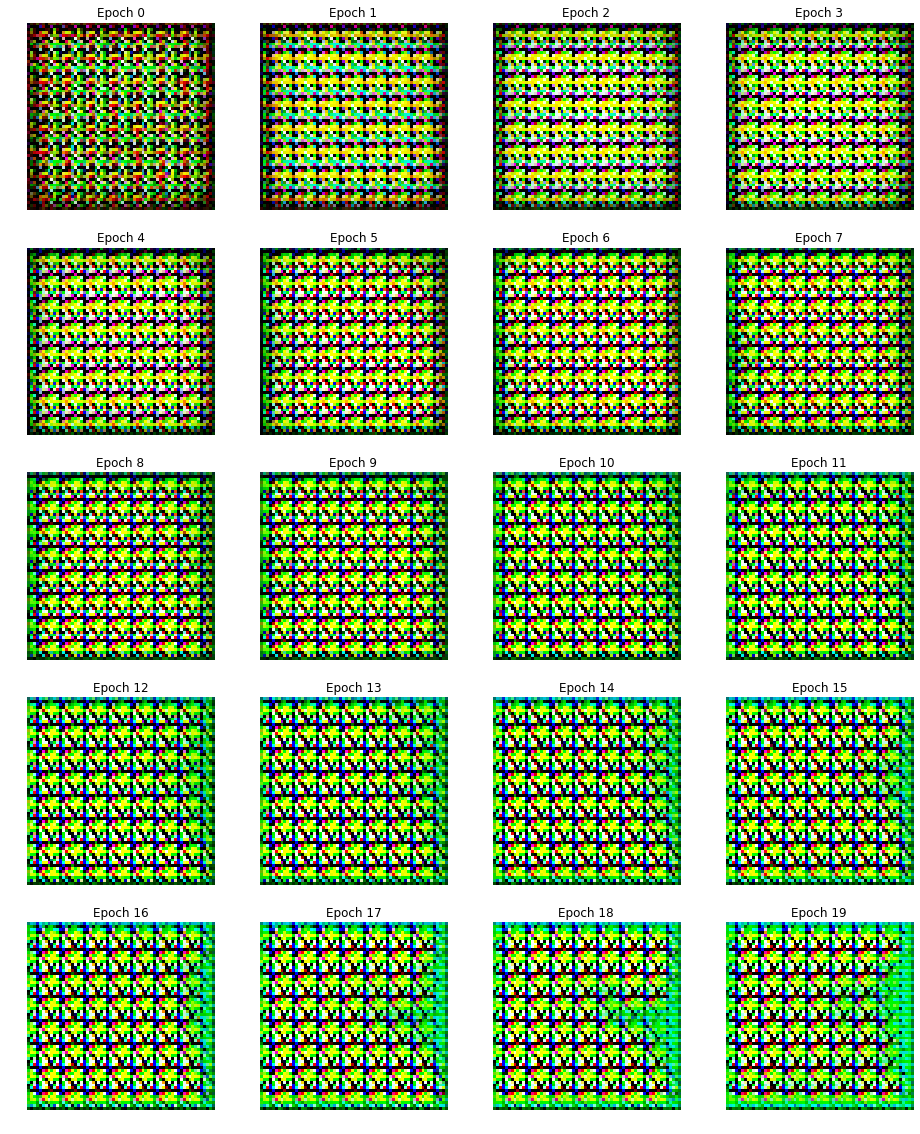

In [34]:
learner.fit(20, 0.001)

In [0]:
??NoisyItem

In [0]:
!cat /usr/local/lib/python3.6/dist-packages/fastai/vision/gan.py

In [0]:
!cat /usr/local/lib/python3.6/dist-packages/fastai/datasets.py

In [0]:
??Learner

PENDING:

* Check if critic is reinitialized because it's giving strange predictions for real faces.
* Clean gan_loss_from_func
* Possibility of defining a CustomGANLearner in order to establish a different GANLoss
* The critic is trained for receiving 224x224 images, not 64x64, and minimum input size for resnet18 is supposed to be 224x224. Resized automatically/adaptive avgpool makes it irrelevant? If not, expand generator to create 224x224 images.
* Revisit transforms (get_data)
* Find extra loss functions for generator and pass it to gan_loss_from_func. Maybe pixel loss???, feature loss???
* What if I make the final convolution a normal convolution with in_channels=out_channels (probably together with uncommenting the last ConvBlock call)? 
* Try replacing first convolution with FC layer + reshape (view)
*  Further research about that first layer "project and reshape"
*  Using a pretrained critic might be a bad idea, especially thinking about the gradients used by the generator to improve
* Use pretrained critic AND generator. For the generator, train to generate images from a different dataset than the used for training the GAN.